In [858]:
%matplotlib inline
# https://scipy.github.io/devdocs/reference/spatial.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree.query_radius

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from PIL import Image
from scipy.spatial import distance
from operator import itemgetter
from sklearn.neighbors import KDTree
import time
import imageio
import os
import glob

In [859]:
IMG_PATH = './dataset/*.jpg'
TEST_IMG = './dataset/0.jpg'

In [860]:
img = Image.open(TEST_IMG)
w, h = img.__dict__['_size']

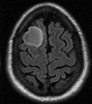

In [861]:
img = Image.open(TEST_IMG).resize((int(w/4), int(h/4)))
display(img)

In [862]:
mat = np.asarray(img)
pixels = np.concatenate([row for row in mat])

In [863]:
# for row in mat:
#     for pixel in row:
#         print(pixel)

# M = []
# for i in range(len(mat)):
#     for j in range(len(mat[i])):
#         pixel = mat[i, j]
#         M.append(np.concatenate((pixel, [i, j])))
# M = np.array(M)    

# M = []
# for i in range(len(mat)):
#     for j in range(len(mat[i])):
#         pixel = mat[i, j]
#         M.append(np.array([''.join([str(p) for p in pixel]), i, j], dtype=object))
# M = np.array(M)     

In [864]:
# M_DF = pd.DataFrame(M, columns=['RGB', 'i', 'j'])

In [865]:
# sns.scatterplot(data=M_DF, x='j', y='i', hue='RGB', legend=False)

In [926]:
UNDEFINED = 0
NOISE = 1
EPS = 0.9
TRESHOLD = 75

In [927]:
class DBScan():
    def __init__(self, data, eps, treshold, m='euclidean'):
        self.data = data        # database
        self.KDT = KDTree(data) 
        self.e = eps            # radius
        self.t = treshold       # minPoints: density treshold

        # cluster of i-th training example
        self.label = np.array([UNDEFINED for _ in range(len(data))])        
    
    def region_query(self, p):
        N = self.KDT.query_radius([p], r=self.e)[0]                 # print(f'First N: {N}')
        N = [n for n in N if self.label[n] in [UNDEFINED, NOISE] ]  # print(f'Filtered N: {N}')
        return np.array(N, dtype=object)

    def dbs(self):
        c = 1
        for i in range(len(self.data)):
            label_p = self.label[i]         # label of i-th training example
            # print(f'current {i} -> {list(self.data[i])}')
            if label_p != UNDEFINED:
                continue
            # get index of nearest neighbors of i-th trainig example
            NN = self.region_query(self.data[i])
            # print(f'\t NN: {NN}')
            # print(f'\t {len(NN)}')
            # print(f'\t NN: {[list(self.data[_]) for _ in NN]}')

            # print(f'{label_p}\t{self.label[i]}')
            if len(NN) < self.t:
                self.label[i] = NOISE
                continue
            # print(f'{label_p}\t{self.label[i]}')
            c += 1
            # print(c, end=", ")
            self.label[i] = c
            # print(f'{label_p}\t{self.label[i]}')

            # S <- N \ {p}
            S = [NN[_] for _ in np.where(NN!=i)[0]]
            # print(f'\t S: {S}')
            # print(f'\t {len(S)}')

            for q in S:
                label_curr = self.label[q]
                if label_curr == NOISE:
                    self.label[q] = c
                if label_curr != UNDEFINED:
                    continue
                NE = self.region_query(self.data[q])
                self.label[q] = c
                if len(NE) < self.t:
                    continue
                # past_S = S
                S += [_ for _ in NE if _ not in S]
                # print(q)
                # if past_S != S:
                #     print(S)
                #     time.sleep(3)
            # print(f'\t S: {[list(self.data[_]) for _ in S]}')
            # print(np.unique(self.label), end=" ")
        return self.label
        
    def execute(self):
        self.dbs()

In [928]:
M = []
for i in range(len(mat)):
    for j in range(len(mat[i])):
        pixel = mat[i, j]
        M.append(np.array(list(pixel) + [i, j], dtype=object))
M = np.array(M)
# np.random.shuffle(M)

In [929]:
pixels_db = M[: , 0:3]
pixels_db

array([[7, 7, 7],
       [7, 7, 7],
       [6, 6, 6],
       ...,
       [5, 5, 5],
       [5, 5, 5],
       [5, 5, 5]], dtype=object)

In [930]:
# print(np.unique(pixels).shape)
# print(pixels.shape)

In [931]:
# np.random.shuffle(pixels)
dbscan = DBScan(pixels_db, EPS, TRESHOLD)

In [932]:
result = dbscan.dbs()

In [933]:
print(np.unique(result))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


In [934]:
ij_cluster = pd.DataFrame()
ij_cluster['i'] = M[: , -2]
ij_cluster['j'] = M[: , -1]
ij_cluster['clusters'] = result

In [935]:
ij_cluster

,i,j,clusters
0,0,0,2
1,0,1,2
2,0,2,3
3,0,3,4
4,0,4,4
...,...,...,...
9563,103,87,5
9564,103,88,5
9565,103,89,6
9566,103,90,6


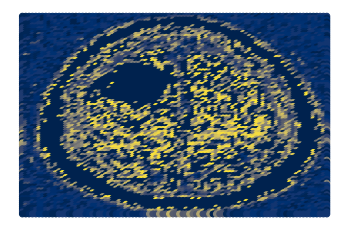

In [944]:
cmap, norm = matplotlib.colors.from_levels_and_colors([0, 1, 2, 3, 4], ['lime', 'black', 'silver','rebeccapurple'])
X = ij_cluster['j'].tolist()
Y = ij_cluster['i'].tolist()
plt.scatter(X,Y,c=ij_cluster['clusters'].tolist(), cmap='cividis')
plt.axis('off')
plt.gca().invert_yaxis()
plt.show()

In [937]:
# print(vars(dbscan))

In [938]:
# ls = np.array([
#     [1, 2, 3],
#     [4, 5, 6],
#     [7, 8, 9]
# ])
# ls[0] = 5
# print(ls)

In [939]:
# https://datagy.io/python-print-objects-attributes/
# print(dir(dbscan))
# print(dbscan.__dict__)
# print(vars(dbscan))

In [940]:
# tup_list = []
# for img in glob.glob(IMG_PATH):
#     tup_list.append(np.array(Image.open(img)).shape)
# x, y, z = zip(*tup_list)
# dim = (np.median(sorted(x)), np.median(sorted(y)))
# print(dim)

# https://www.geeksforgeeks.org/python-column-mean-in-tuple-list/
# https://stackoverflow.com/questions/26392336/importing-images-from-a-directory-python-to-list-or-dictionary